In [1]:
import numpy as np
from imageio import imwrite
from glob import glob
import tarfile
import urllib
import os
import matplotlib.pyplot as plt
import mxnet as mx
import mxnet.ndarray as F
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

/home/ubuntu/src/anaconda2/envs/mxnet1/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/home/ubuntu/src/anaconda2/envs/mxnet1/lib/python2.7/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
/home/ubuntu/src/anaconda2/envs/mxnet1/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Setup

Download data

In [ ]:
if not os.path.exists('/dev/shm/brain_mri'): os.mkdir('/dev/shm/brain_mri')

In [ ]:
urllib.urlretrieve ("https://s3.amazonaws.com/amlc-seg-labs/disc1.tar.gz", "/dev/shm/brain_mri/disc1.tar.gz")

with tarfile.open('/dev/shm/brain_mri/disc1.tar.gz') as tar:
    tar.extractall('/dev/shm/brain_mri')

In [2]:
dtype = np.dtype('>u2')

image = np.fromfile(
    open('/dev/shm/brain_mri/disc1/OAS1_0002_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0002_MR1_mpr_n4_anon_111_t88_gfc.img', 'rb'),
    dtype).reshape((176, 208, 176))

mask = np.fromfile(
    open('/dev/shm/brain_mri/disc1/OAS1_0002_MR1/PROCESSED/MPRAGE/T88_111/OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc.img', 'rb'),
    dtype).reshape((176, 208, 176))

segmentation = np.fromfile(
    open('/dev/shm/brain_mri/disc1/OAS1_0002_MR1/FSL_SEG/OAS1_0002_MR1_mpr_n4_anon_111_t88_masked_gfc_fseg.img', 'rb'),
    dtype).reshape((176, 208, 88))

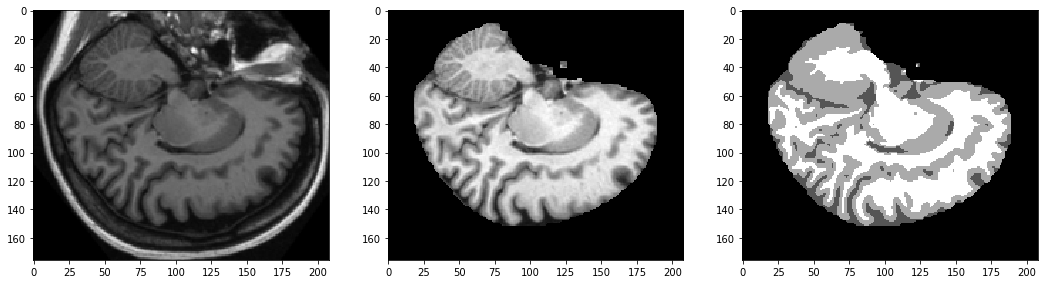

In [3]:
width = 18
height = 18
plt.figure(figsize=(width, height))
plt.subplot(131)
plt.imshow(image[:,:,101], cmap = plt.cm.gray)
plt.subplot(132)
plt.imshow(mask[:,:,101], cmap = plt.cm.gray)
plt.subplot(133)
plt.imshow(segmentation[:,:,50], cmap = plt.cm.gray)

## Load Data

In [2]:
images = glob('/dev/shm/brain_mri/disc1/*/*/*/*/*t88_gfc.img')
masks = glob('/dev/shm/brain_mri/disc1/*/*/*t88_masked_gfc_fseg.img')
images.sort()
masks.sort()

In [3]:
train_images, validation_images, train_masks, validation_masks = train_test_split(images, masks, test_size=0.2, random_state=1984)

In [4]:
def load_frames(images):
    frames = []
    for image in images:
        frames.append(
            np.fromfile(open(image, 'rb'), dtype='>u2')
            .reshape((176, 208, 176))[:,:,np.arange(1, 176, 2)]
            .transpose((2, 0, 1))
        )
    return np.concatenate(frames)

In [5]:
def load_masks(masks):
    mask_arrays = []
    for mask in masks:
        tmp = np.fromfile(open(mask, 'rb'), dtype='>u2').reshape((176, 208, 88)).transpose((2, 0, 1))
        mask_arrays.append(tmp)
    return np.concatenate(mask_arrays)

In [6]:
train_X = load_frames(train_images)
validation_X = load_frames(validation_images)
train_Y = load_masks(train_masks)
validation_Y = load_masks(validation_masks)

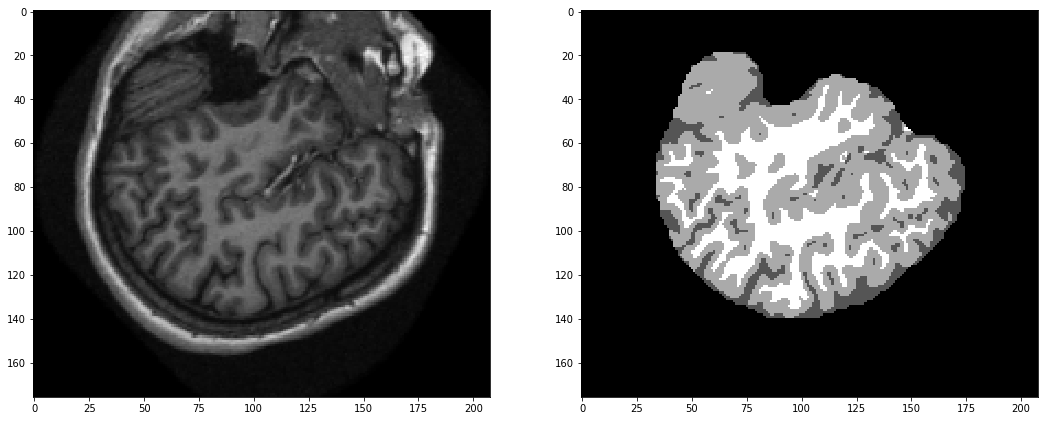

In [7]:
idx= 2001

width = 18
height = 18
plt.figure(figsize=(width, height))
plt.subplot(121)
plt.imshow(train_X[idx], cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(train_Y[idx], cmap=plt.cm.gray)

Segmentation isn't complete, it's approximate.

(array([73964295.,        0.,        0.,  5811843.,        0.,        0.,
        12047820.,        0.,        0.,  8042666.]),
 array([  0. ,  77.1, 154.2, 231.3, 308.4, 385.5, 462.6, 539.7, 616.8,
        693.9, 771. ]),
 <a list of 10 Patch objects>)

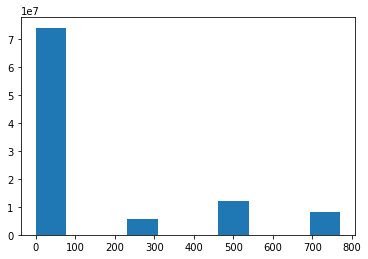

In [8]:
plt.hist(train_Y.flatten())

Split at 150, 400, 625

In [9]:
def normalize_segmentation(raw_segmentation):
    raw_segmentation[raw_segmentation < 150] = 0
    raw_segmentation[np.where((150 < raw_segmentation) & (raw_segmentation < 400))] = 1
    raw_segmentation[np.where((400 < raw_segmentation) & (raw_segmentation < 625))] = 2
    raw_segmentation[raw_segmentation > 625] = 3
    return raw_segmentation

In [10]:
train_Y = normalize_segmentation(train_Y)
validation_Y = normalize_segmentation(validation_Y)

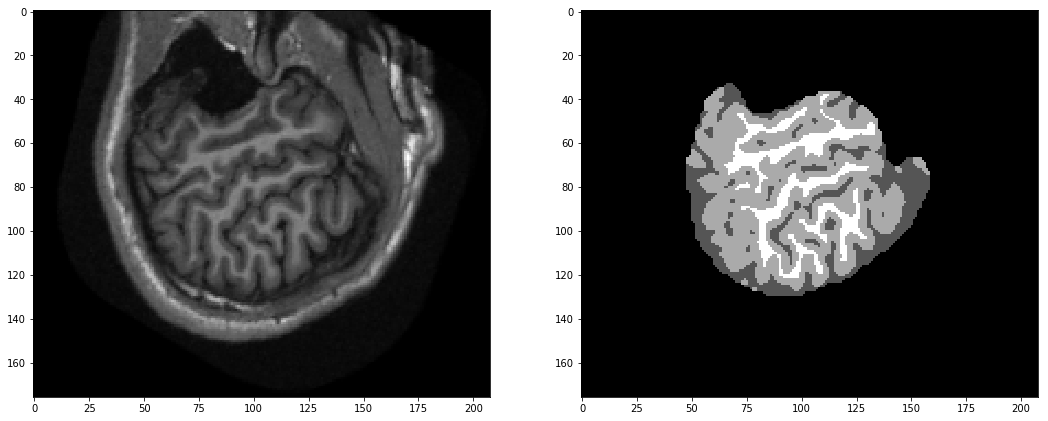

In [11]:
idx= 16

width = 18
height = 18
plt.figure(figsize=(width, height))
plt.subplot(121)
plt.imshow(train_X[idx], cmap=plt.cm.gray)
plt.subplot(122)
plt.imshow(train_Y[idx], cmap=plt.cm.gray)

In [12]:
train_X.shape

(2728, 176, 208)

In [13]:
train_Y.shape

(2728, 176, 208)

## Model

In [14]:
def avg_dice_coef_loss(y_true, y_pred, class_weights):    
    intersection = mx.sym.sum(mx.sym.elemwise_mul(y_true, y_pred), axis=(2, 3))
    scores =  -mx.sym.broadcast_div((2. * intersection + 1.),
                                 (mx.sym.broadcast_add(mx.sym.sum(y_true, axis=(2, 3)),
                                                       mx.sym.sum(y_pred, axis=(2, 3))) + 1.))
    average = mx.sym.sum(mx.sym.broadcast_mul(scores, class_weights), axis=1)
    return average

def channel_wise_softmax(decoded):
    denominator = mx.sym.sum(mx.sym.exp(decoded), axis=1, keepdims=True)
    return mx.sym.broadcast_div(mx.sym.exp(decoded), denominator)

In [15]:
@mx.init.register
class MyConstant(mx.init.Initializer):
    def __init__(self, value):
        super(MyConstant, self).__init__(value=value)
        self.value = value

    def _init_weight(self, _, arr):
        arr[:] = mx.nd.array(self.value)

In [16]:
###############################
###     UNet Architecture   ###
###############################

def conv_block(inp, num_filter, kernel, pad, block, conv_block):
    conv = mx.sym.Convolution(inp, num_filter=num_filter, kernel=kernel, pad=pad, name='conv%i_%i' % (block, conv_block))
    conv = mx.sym.BatchNorm(conv, fix_gamma=True, name='bn%i_%i' % (block, conv_block))
    conv = mx.sym.Activation(conv, act_type='relu', name='relu%i_%i' % (block, conv_block))
    return conv

def down_block(inp, num_filter, kernel, pad, block, pool=True):
    conv = conv_block(inp, num_filter, kernel, pad, block, 1)
    conv = conv_block(conv, num_filter, kernel, pad, block, 2)
    if pool:
        pool = mx.sym.Pooling(conv, kernel=(2,2), stride=(2,2), pool_type='max', name='pool_%i' % block)
        return pool, conv
    return conv

def down_branch(inp):
    pool1, conv1 = down_block(inp, num_filter=32, kernel=(3,3), pad=(1,1), block=1)
    pool2, conv2 = down_block(pool1, num_filter=64, kernel=(3,3), pad=(1,1), block=2)
    pool3, conv3 = down_block(pool2, num_filter=128, kernel=(3,3), pad=(1,1), block=3)
    pool4, conv4 = down_block(pool3, num_filter=256, kernel=(3,3), pad=(1,1), block=4)
    conv5 = down_block(pool4, num_filter=512, kernel=(3,3), pad=(1,1), block=5, pool=False)
    return [conv5, conv4, conv3, conv2, conv1]

def up_block(inp, down_feature, num_filter, kernel, pad, block):
    trans_conv = mx.sym.Deconvolution(inp, num_filter=num_filter, kernel=(2,2), stride=(2,2), no_bias=True,
                                      name='trans_conv_%i' % block)
    up = mx.sym.concat(*[trans_conv, down_feature], dim=1, name='concat_%i' % block)
    conv = conv_block(up, num_filter, kernel, pad, block, 1)
    conv = conv_block(conv, num_filter, kernel, pad, block, 2)
    return conv

def up_branch(down_features, num_classes):
    conv6 = up_block(down_features[0], down_features[1], num_filter=256, kernel=(3,3), pad=(1,1), block=6)
    conv7 = up_block(conv6, down_features[2], num_filter=128, kernel=(3,3), pad=(1,1), block=7)
    conv8 = up_block(conv7, down_features[3], num_filter=64, kernel=(3,3), pad=(1,1), block=8)
    conv9 = up_block(conv8, down_features[4], num_filter=64, kernel=(3,3), pad=(1,1), block=9)
    conv10 = mx.sym.Convolution(conv9, num_filter=num_classes, kernel=(1,1), name='conv10_1')
    return conv10

def build_unet(num_classes, inference=False, class_weights=None):
    data = mx.sym.Variable(name='data')
    down_features = down_branch(data)
    decoded = up_branch(down_features, num_classes)
    decoded = mx.sym.sigmoid(decoded, name='sigmoid')
    if inference:
        return decoded
    else:
        channel_softmax = channel_wise_softmax(decoded)
        label = mx.sym.Variable(name='label')
        if class_weights is None:
            class_weights = np.ones((1, 4)).tolist()
        else:
            class_weights = class_weights.tolist()
        class_weights = mx.sym.Variable('constant_class_weights', shape = (1, 4),
                                        init = MyConstant(value = class_weights))
        class_weights = mx.sym.BlockGrad(class_weights)
        loss = mx.sym.MakeLoss(avg_dice_coef_loss(label, channel_softmax, class_weights), normalization='batch')
        mask_output = mx.sym.BlockGrad(decoded, 'mask')
        out = mx.sym.Group([loss, mask_output])
        return out

In [17]:
class SpatialDropout(mx.operator.CustomOp):
    def __init__(self, p, num_filters, ctx):
        self._p = float(p)
        self._num_filters = int(num_filters)
        self._ctx = ctx
        self._spatial_dropout_mask = F.ones(shape=(1, 1, 1, 1), ctx=self._ctx)
        
    def forward(self, is_train, req, in_data, out_data, aux):
        x = in_data[0]
        if is_train:
            self._spatial_dropout_mask = F.broadcast_greater(
                F.random_uniform(low=0, high=1, shape=(1, self._num_filters, 1, 1), ctx=self._ctx), 
                F.ones(shape=(1, self._num_filters, 1, 1), ctx=self._ctx) * self._p,
                ctx=self._ctx
            )
            y = F.broadcast_mul(x, self._spatial_dropout_mask, ctx=self._ctx) / (1-self._p)
            self.assign(out_data[0], req[0], y)
        else:
            self.assign(out_data[0], req[0], x)
            
    def backward(self, req, out_grad, in_data, out_data, in_grad, aux):
        dy = out_grad[0]
        dx = F.broadcast_mul(self._spatial_dropout_mask, dy)
        self.assign(in_grad[0], req[0], dx)
        
@mx.operator.register('spatial_dropout')
class SpatialDropoutProp(mx.operator.CustomOpProp):
    def __init__(self, p, num_filters):
        super(SpatialDropoutProp, self).__init__(True)
        self._p = p
        self._num_filters = num_filters
        
    def infer_shape(self, in_shapes):
        data_shape = in_shapes[0]
        output_shape = data_shape
        # return 3 lists representing inputs shapes, outputs shapes, and aux data shapes.
        return (data_shape,), (output_shape,), ()
            
    def create_operator(self, ctx, in_shape, in_dtypes):
        return SpatialDropout(self._p, self._num_filters, ctx)
    
def same_padding(inp_dims, outp_dims, strides, kernel):
    inp_h, inp_w = inp_dims[1:]
    outp_h, outp_w = outp_dims
    kernel_h, kernel_w = kernel
    pad_along_height = max((outp_h - 1) * strides[0] + kernel_h - inp_h, 0)
    pad_along_width = max((outp_w - 1) * strides[1] + kernel_w - inp_w, 0)
    pad_top = pad_along_height // 2          
    pad_bottom = pad_along_height - pad_top  
    pad_left = pad_along_width // 2          
    pad_right = pad_along_width - pad_left   
    return (0,0,0,0,pad_top,pad_bottom,pad_left, pad_right)

def initial_block(inp, inp_dims, outp_dims, nb_filter=13, nb_row=3, nb_col=3, strides=(2, 2)):
    
    padded_inp = mx.sym.pad(inp, mode='constant',
                            pad_width=same_padding(inp_dims, outp_dims, strides, kernel=(nb_row, nb_col)), name='init_pad')
    conv = mx.sym.Convolution(padded_inp, num_filter=nb_filter, kernel=(nb_row, nb_col), stride=strides, name='init_conv')
    max_pool = mx.sym.Pooling(inp, kernel=(2,2), stride=(2,2), pool_type='max', name='init_pool')
    merged = mx.sym.concat(*[conv, max_pool], dim=1, name='init_concat')
    return merged

def encoder_bottleneck(inp, inp_filter, output, name, internal_scale=4, asymmetric=0, dilated=0, downsample=False, dropout_rate=0.1):
    # main branch
    internal = output // internal_scale
    encoder = inp

    # 1x1
    input_stride = 2 if downsample else 1  # the 1st 1x1 projection is replaced with a 2x2 convolution when downsampling
    encoder = mx.sym.Convolution(encoder, num_filter=internal, kernel=(input_stride, input_stride),
                                stride=(input_stride, input_stride), no_bias=True, name="conv1_%i"%name)
    # Batch normalization + PReLU
    encoder = mx.sym.BatchNorm(encoder, momentum=0.1, name="bn1_%i"%name)
    encoder = mx.sym.LeakyReLU(encoder, act_type='prelu', name='prelu1_%i'%name)
    # conv
    if not asymmetric and not dilated:
        encoder = mx.sym.Convolution(encoder, num_filter=internal, kernel=(3,3), pad=(1,1), name="conv2_%i"%name)
    elif asymmetric:
        encoder = mx.sym.Convolution(encoder, num_filter=internal, kernel=(1, asymmetric),
                                     pad=(0, asymmetric// 2), no_bias=True, name="conv3_%i"%name)
        encoder = mx.sym.Convolution(encoder, num_filter=internal, kernel=(asymmetric, 1),
                                     pad=(asymmetric// 2, 0), name="conv4_%i"%name)
    elif dilated:
        encoder = mx.sym.Convolution(encoder, num_filter=internal, kernel=(3,3),
                                     dilate=(dilated, dilated), pad=((3+(dilated-1)*2)// 2, (3+(dilated-1)*2)// 2),
                                     name="conv2_%i"%name)
    else:
        raise(Exception('You shouldn\'t be here'))
    encoder = mx.sym.BatchNorm(encoder, momentum=0.1, name='bn2_%i'%name)
    encoder = mx.sym.LeakyReLU(encoder, act_type='prelu', name='prelu2_%i'%name)    
    # 1x1
    encoder = mx.sym.Convolution(encoder, num_filter=output, kernel=(1,1), no_bias=True, name="conv5_%i"%name)
    encoder = mx.sym.BatchNorm(encoder, momentum=0.1, name='bn3_%i'%name)
    encoder = mx.sym.Custom(encoder, op_type='spatial_dropout', name='spatial_dropout_%i' % name,
                            p = dropout_rate, num_filters = output)
    other = inp
    # other branch
    if downsample:
        other = mx.sym.Pooling(other, kernel=(2,2), stride=(2,2), pool_type='max', name='pool1_%i'%name)
        other = mx.sym.transpose(other, axes=(0,2,1,3), name='trans1_%i'%name)
        pad_feature_maps = output - inp_filter
        other = mx.sym.pad(other, mode='constant', pad_width=(0,0,0,0,0,pad_feature_maps,0,0), name='pad1_%i'%name)
        other = mx.sym.transpose(other, axes=(0,2,1,3), name='trans2_%i'%name)
    encoder = mx.sym.broadcast_add(encoder, other, name='add1_%i'%name)
    encoder = mx.sym.LeakyReLU(encoder, act_type='prelu', name='prelu3_%i'%name)
    return encoder

def build_encoder(inp, inp_dims, dropout_rate=0.01):
    enet = initial_block(inp, inp_dims=inp_dims, outp_dims=(inp_dims[1]//2, inp_dims[2]//2))
    enet = mx.sym.BatchNorm(enet, momentum=0.1, name='bn_0')
    encet = mx.sym.LeakyReLU(enet, act_type='prelu', name='prelu_0')
    enet = encoder_bottleneck(enet, 13+inp_dims[0], 64, downsample=True, dropout_rate=dropout_rate, name=1)  # bottleneck 1.0
    for n in range(4):
        enet = encoder_bottleneck(enet, 64, 64, dropout_rate=dropout_rate, name=n+10)  # bottleneck 1.i
    
    enet = encoder_bottleneck(enet, 64, 128, downsample=True, name=19)  # bottleneck 2.0
    # bottleneck 2.x and 3.x
    for n in range(2):
        enet = encoder_bottleneck(enet, 128, 128, name=n*10+20)  # bottleneck 2.1
        enet = encoder_bottleneck(enet, 128, 128, dilated=2, name=n*10+21)  # bottleneck 2.2
        enet = encoder_bottleneck(enet, 128, 128, asymmetric=5, name=n*10+22)  # bottleneck 2.3
        enet = encoder_bottleneck(enet, 128, 128, dilated=4, name=n*10+23)  # bottleneck 2.4
        enet = encoder_bottleneck(enet, 128, 128, name=n*10+24)  # bottleneck 2.5
        enet = encoder_bottleneck(enet, 128, 128, dilated=8, name=n*10+25)  # bottleneck 2.6
        enet = encoder_bottleneck(enet, 128, 128, asymmetric=5, name=n*10+26)  # bottleneck 2.7
        enet = encoder_bottleneck(enet, 128, 128, dilated=16, name=n*10+27)  # bottleneck 2.8
    return enet

def decoder_bottleneck(encoder, inp_filter, output, upsample=False, upsample_dims=None, reverse_module=False, name=0):
    internal = output // 4
    
    x = mx.sym.Convolution(encoder, num_filter=internal, kernel=(1,1), no_bias=True, name="conv6_%i"%name)
    x = mx.sym.BatchNorm(x, momentum=0.1, name='bn4_%i'%name)
    x = mx.sym.Activation(x, act_type='relu', name='relu1_%i'%name)
    if not upsample:
        x = mx.sym.Convolution(x, num_filter=internal, kernel=(3,3), pad=(1,1), no_bias=False, name="conv7_%i"%name)
    else:
        x = mx.sym.Deconvolution(x, num_filter=internal, kernel=(3, 3), stride=(2, 2), target_shape=upsample_dims, name="dconv1_%i"%name)
    x = mx.sym.BatchNorm(x, momentum=0.1, name='bn5_%i'%name)
    x = mx.sym.Activation(x, act_type='relu', name='relu2_%i'%name)
    x = mx.sym.Convolution(x, num_filter=output, kernel=(1,1), no_bias=True, name="conv8_%i"%name)
    other = encoder
    if inp_filter != output or upsample:
        other = mx.sym.Convolution(other, num_filter=output, kernel=(1,1), no_bias=True, name="conv9_%i"%name)
        other = mx.sym.BatchNorm(other, momentum=0.1, name='bn6_%i'%name)
        if upsample and reverse_module is not False:
            other = mx.sym.UpSampling(other, scale=2, sample_type='nearest', name="upsample1_%i"%name)        
    if upsample and reverse_module is False:
        decoder = x
    else:
        x = mx.sym.BatchNorm(x, momentum=0.1, name='bn7_%i'%name)
        decoder = mx.sym.broadcast_add(x, other, name='add2_%i'%name)
        decoder = mx.sym.Activation(decoder, act_type='relu', name='relu3_%i'%name)
    return decoder

def build_decoder(encoder, nc, output_shape=(3, 512, 512)):
    enet = decoder_bottleneck(encoder, 128, 64, upsample=True, upsample_dims=(output_shape[1]//4, output_shape[2]//4), reverse_module=True, name=20)  # bottleneck 4.0
    enet = decoder_bottleneck(enet, 64, 64, name=21)  # bottleneck 4.1
    enet = decoder_bottleneck(enet, 64, 64, name=22)  # bottleneck 4.2
    enet = decoder_bottleneck(enet, 64, 16, upsample=True, upsample_dims=(output_shape[1]//2, output_shape[2]//2), reverse_module=True, name=23)  # bottleneck 5.0
    enet = decoder_bottleneck(enet, 16, 16, name=24)  # bottleneck 5.1

    enet = mx.sym.Deconvolution(enet, num_filter=nc, kernel=(2, 2), stride=(2, 2), target_shape=(output_shape[1],output_shape[2]), name='dconv2')
    return enet

def build_enet(inp_dims, num_classes, inference=False, class_weights = None):
    data = mx.sym.Variable(name='data')
    encoder = build_encoder(data, inp_dims=inp_dims)
    decoded = build_decoder(encoder, num_classes, output_shape=inp_dims)
    decoded = mx.sym.sigmoid(decoded, name='sigmoid')
    if inference:
        return decoded
    else:
        channel_softmax = channel_wise_softmax(decoded)
        label = mx.sym.Variable(name='label')
        if class_weights is None:
            class_weights = np.ones((1, 4)).tolist()
        else:
            class_weights = class_weights.tolist()
        class_weights = mx.sym.Variable('constant_class_weights', shape = (1, 4),
                                        init = MyConstant(value = class_weights))
        class_weights = mx.sym.BlockGrad(class_weights)
        loss = mx.sym.MakeLoss(avg_dice_coef_loss(label, channel_softmax, class_weights), normalization='batch')
        mask_output = mx.sym.BlockGrad(decoded, 'mask')
        out = mx.sym.Group([loss, mask_output])
        return out

## Training

### UNet

In [18]:
mean = train_X.mean()
std = train_X.std()
params = {
    'mean':mean,
    'std':std
}

In [19]:
def preprocess_X(X, params):
    normalized_X = (X - params['mean']) / params['std']
    return np.expand_dims(normalized_X, 1)

def postprocess_X(X, params):
    X = X*params['std'] + params['mean']
    return np.clip(X[:,0,:,:], 0, 65535).astype(np.uint16)

def preprocess_Y(Y, num_classes):    
    one_hot_mask = np.zeros((Y.shape[0],)+(num_classes,) + Y.shape[1:])
    for c in range(num_classes):
        one_hot_mask[:,c,:,:][Y==c] = 1
    return one_hot_mask

def postprocess_Y(Y):
    return np.argmax(Y, axis=1)

In [20]:
train_X_norm = preprocess_X(train_X, params)
validation_X_norm = preprocess_X(validation_X, params)
train_Y_one_hot = preprocess_Y(train_Y, 4)
validation_Y_one_hot = preprocess_Y(validation_Y, 4)

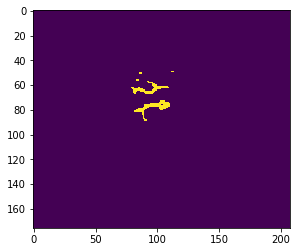

In [21]:
plt.imshow(train_Y_one_hot[100][3])

In [22]:
unique, counts = np.unique(train_Y, return_counts=True)

In [23]:
frequencies = counts/np.sum(counts.astype(float))

In [24]:
frequencies

array([0.74063077, 0.05819605, 0.1206391 , 0.08053407])

In [25]:
class_weights = np.array([[1/f for f in frequencies]])

In [27]:
batch_size = 16
num_gpus = 8
ctx = [mx.gpu(i) for i in range(num_gpus)]
learning_rate = 1E-3
beta1 = 0.9
beta2 = 0.99
epochs = 100
burn_in = 0

In [28]:
train_iter = train_iter = mx.io.NDArrayIter(data = train_X_norm, label=train_Y_one_hot, batch_size=batch_size, shuffle=True, label_name='label')
validation_iter = mx.io.NDArrayIter(data = validation_X_norm, label=validation_Y_one_hot, batch_size=batch_size, shuffle=False, label_name='label')
data_shape = (batch_size,) + train_X_norm.shape[1:]

In [29]:
train_iter.provide_data

[DataDesc[data,(16, 1L, 176L, 208L),<type 'numpy.float32'>,NCHW]]

In [30]:
sym = build_unet(4, class_weights=class_weights)

net = mx.mod.Module(sym, context=ctx, data_names=('data',), label_names=('label',))
net.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
net.init_params(mx.initializer.Xavier(magnitude=6))
net.init_optimizer(optimizer = 'adam', 
                           optimizer_params=(
                               ('learning_rate', learning_rate),
                               ('beta1', beta1),
                               ('beta2', beta2)
                          ))

In [33]:
net.output_shapes

[('makeloss0_output', (16,)), ('mask_output', (16, 4L, 176L, 208L))]

In [34]:
smoothing_constant = .01
curr_losses = []
moving_losses = []
i = 0
best_val_loss = np.inf
for e in range(epochs):
    while True:
        # if iterator is out, reset and move to next epoch
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        # forward and backward pass
        net.forward_backward(batch)
        loss = net.get_outputs()[0]
        # optimizer step
        net.update()
        # loss calculations
        curr_loss = F.mean(loss).asscalar()
        curr_losses.append(curr_loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        moving_losses.append(moving_loss)
        i += 1
    # loss metrics
    val_losses = []
    for batch in validation_iter:
        net.forward(batch)
        loss = net.get_outputs()[0]
        val_losses.append(F.mean(loss).asscalar())
    validation_iter.reset()
    # early stopping
    val_loss = np.mean(val_losses)
    # early stopping by saving the model w/ best validation metric
    if e > burn_in and val_loss < best_val_loss:
        best_val_loss = val_loss
        net.save_checkpoint('best_unet', 0)
        print("Best model at Epoch %i" %(e+1))
    print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+1, moving_loss, val_loss))

Epoch 1: Moving Training Loss -7.28072, Validation Loss -8.10089
Best model at Epoch 2
Epoch 2: Moving Training Loss -8.12489, Validation Loss -8.19958
Best model at Epoch 3
Epoch 3: Moving Training Loss -8.32333, Validation Loss -8.25009
Best model at Epoch 4
Epoch 4: Moving Training Loss -8.38819, Validation Loss -8.28973
Best model at Epoch 5
Epoch 5: Moving Training Loss -8.42428, Validation Loss -8.30154
Best model at Epoch 6
Epoch 6: Moving Training Loss -8.45430, Validation Loss -8.33845
Best model at Epoch 7
Epoch 7: Moving Training Loss -8.48330, Validation Loss -8.34614
Best model at Epoch 8
Epoch 8: Moving Training Loss -8.50620, Validation Loss -8.36318
Best model at Epoch 9
Epoch 9: Moving Training Loss -8.52950, Validation Loss -8.37636
Epoch 10: Moving Training Loss -8.54321, Validation Loss -8.34675
Epoch 11: Moving Training Loss -8.57091, Validation Loss -8.34936
Best model at Epoch 12
Epoch 12: Moving Training Loss -8.60283, Validation Loss -8.38649
Best model at Epoc

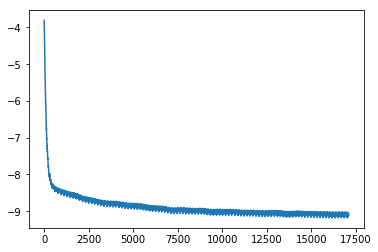

In [35]:
plt.plot(moving_losses)

In [38]:
net.load_params('best_unet-0000.params')

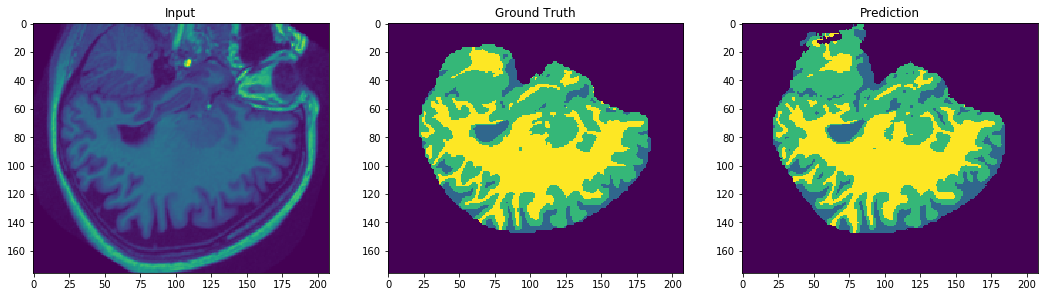

In [49]:
batch = next(validation_iter)
net.forward(batch)
output = net.get_outputs()

width = 18
height = 18
plt.figure(figsize=(width, height))
plt.subplot(131)
plt.title('Input')
plt.imshow(postprocess_X(batch.data[0].asnumpy(), params)[0])
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(postprocess_Y(batch.label[0].asnumpy())[1])
plt.subplot(133)
plt.title('Prediction')
plt.imshow(postprocess_Y(output[1].asnumpy())[1])

In [62]:
validation_iter.reset()
ground_truths = []
outputs = []
for batch in validation_iter:
    net.forward(batch)
    ground_truths.append(postprocess_Y(batch.label[0].asnumpy()))
    outputs.append(postprocess_Y(net.get_outputs()[1].asnumpy()))
ground_truths = np.concatenate(ground_truths)
outputs = np.concatenate(outputs)
ground_truths = ground_truths.flatten()
outputs = outputs.flatten()

In [73]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[18559025   183882    85889   258764]
 [   31855  1155567   110482      774]
 [    8465   274568  2770083   198915]
 [    1446     1342   157965  1973010]]
Normalized confusion matrix
[[9.72e-01 9.63e-03 4.50e-03 1.36e-02]
 [2.45e-02 8.90e-01 8.51e-02 5.96e-04]
 [2.60e-03 8.44e-02 8.52e-01 6.12e-02]
 [6.78e-04 6.29e-04 7.40e-02 9.25e-01]]


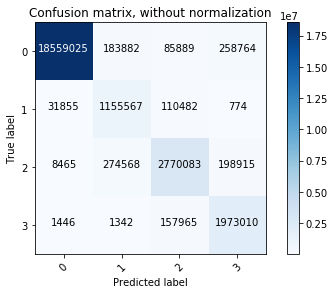

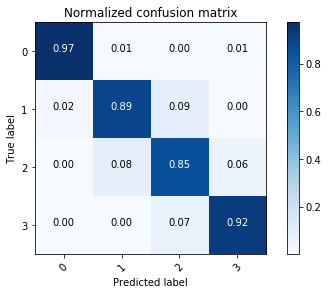

In [74]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, outputs)
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### E-Net

In [75]:
batch_size = 16
num_gpus = 8
ctx = [mx.gpu(i) for i in range(num_gpus)]
learning_rate = 1E-3
beta1 = 0.9
beta2 = 0.99
epochs = 100
burn_in = 0

In [76]:
train_iter = train_iter = mx.io.NDArrayIter(data = train_X_norm, label=train_Y_one_hot, batch_size=batch_size, shuffle=True, label_name='label')
validation_iter = mx.io.NDArrayIter(data = validation_X_norm, label=validation_Y_one_hot, batch_size=batch_size, shuffle=False, label_name='label')
data_shape = (batch_size,) + train_X_norm.shape[1:]

In [77]:
sym = build_enet(inp_dims=data_shape[1:], num_classes=4, class_weights=class_weights)

In [78]:
net = mx.mod.Module(sym, context=ctx, data_names=('data',), label_names=('label',))
net.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
net.init_params(mx.initializer.Xavier(magnitude=6))
net.init_optimizer(optimizer = 'adam', 
                           optimizer_params=(
                               ('learning_rate', learning_rate),
                               ('beta1', beta1),
                               ('beta2', beta2)
                          ))

In [79]:
net.output_shapes

[('makeloss1_output', (16,)), ('mask_output', (16, 4L, 176L, 208L))]

In [80]:
smoothing_constant = .01
curr_losses = []
moving_losses = []
i = 0
best_val_loss = np.inf
for e in range(epochs):
    while True:
        # if iterator is out, reset and move to next epoch
        try:
            batch = next(train_iter)
        except StopIteration:
            train_iter.reset()
            break
        # forward and backward pass
        net.forward_backward(batch)
        loss = net.get_outputs()[0]
        # optimizer step
        net.update()
        # loss calculations
        curr_loss = F.mean(loss).asscalar()
        curr_losses.append(curr_loss)
        moving_loss = (curr_loss if ((i == 0) and (e == 0))
                               else (1 - smoothing_constant) * moving_loss + (smoothing_constant) * curr_loss)
        moving_losses.append(moving_loss)
        i += 1
    # loss metrics
    val_losses = []
    for batch in validation_iter:
        net.forward(batch)
        loss = net.get_outputs()[0]
        val_losses.append(F.mean(loss).asscalar())
    validation_iter.reset()
    # early stopping
    val_loss = np.mean(val_losses)
    # early stopping by saving the model w/ best validation metric
    if e > burn_in and val_loss < best_val_loss:
        best_val_loss = val_loss
        net.save_checkpoint('best_enet', 0)
        print("Best model at Epoch %i" %(e+1))
    print("Epoch %i: Moving Training Loss %0.5f, Validation Loss %0.5f" % (e+1, moving_loss, val_loss))

Epoch 1: Moving Training Loss -6.03160, Validation Loss -6.99199
Best model at Epoch 2
Epoch 2: Moving Training Loss -7.37739, Validation Loss -7.65465
Best model at Epoch 3
Epoch 3: Moving Training Loss -7.84923, Validation Loss -7.84072
Best model at Epoch 4
Epoch 4: Moving Training Loss -8.02599, Validation Loss -7.93216
Best model at Epoch 5
Epoch 5: Moving Training Loss -8.11187, Validation Loss -7.99088
Best model at Epoch 6
Epoch 6: Moving Training Loss -8.16053, Validation Loss -8.02662
Best model at Epoch 7
Epoch 7: Moving Training Loss -8.19803, Validation Loss -8.05276
Best model at Epoch 8
Epoch 8: Moving Training Loss -8.22440, Validation Loss -8.07400
Best model at Epoch 9
Epoch 9: Moving Training Loss -8.25052, Validation Loss -8.10134
Best model at Epoch 10
Epoch 10: Moving Training Loss -8.27237, Validation Loss -8.11664
Best model at Epoch 11
Epoch 11: Moving Training Loss -8.29086, Validation Loss -8.12332
Best model at Epoch 12
Epoch 12: Moving Training Loss -8.3063

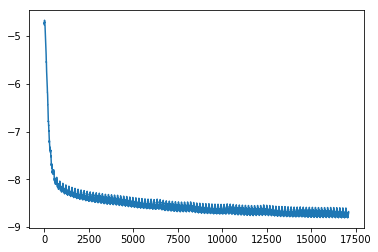

In [81]:
plt.plot(moving_losses)

In [82]:
net.load_params('best_enet-0000.params')

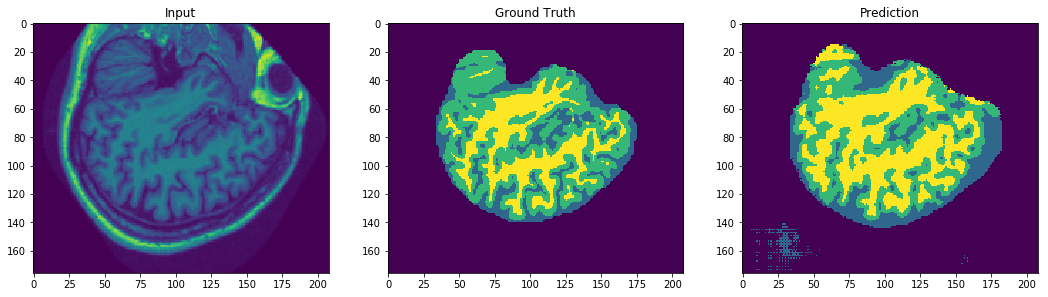

In [88]:
batch = next(validation_iter)
net.forward(batch, is_train=False)
output = net.get_outputs()

width = 18
height = 18
plt.figure(figsize=(width, height))
plt.subplot(131)
plt.title('Input')
plt.imshow(postprocess_X(batch.data[0].asnumpy(), params)[0])
plt.subplot(132)
plt.title('Ground Truth')
plt.imshow(postprocess_Y(batch.label[0].asnumpy())[1])
plt.subplot(133)
plt.title('Prediction')
plt.imshow(postprocess_Y(output[1].asnumpy())[1])

In [89]:
validation_iter.reset()
ground_truths = []
outputs = []
for batch in validation_iter:
    net.forward(batch)
    ground_truths.append(postprocess_Y(batch.label[0].asnumpy()))
    outputs.append(postprocess_Y(net.get_outputs()[1].asnumpy()))
ground_truths = np.concatenate(ground_truths)
outputs = np.concatenate(outputs)
ground_truths = ground_truths.flatten()
outputs = outputs.flatten()

Confusion matrix, without normalization
[[18118630   315071   235584   418275]
 [   31996  1127456   137758     1468]
 [    8532   327702  2634070   281727]
 [    1438     4579   178598  1949148]]
Normalized confusion matrix
[[9.49e-01 1.65e-02 1.23e-02 2.19e-02]
 [2.46e-02 8.68e-01 1.06e-01 1.13e-03]
 [2.62e-03 1.01e-01 8.10e-01 8.66e-02]
 [6.74e-04 2.15e-03 8.37e-02 9.13e-01]]


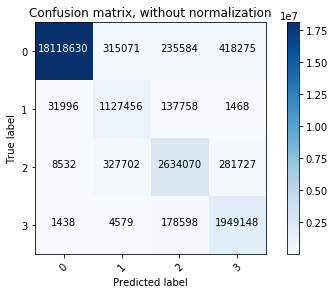

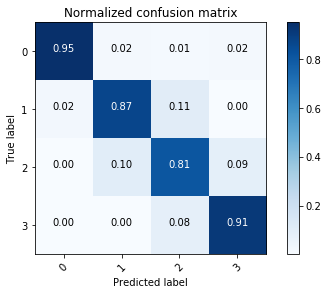

In [90]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(ground_truths, outputs)
np.set_printoptions(precision=2)
class_names = [0, 1, 2, 3]

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

## Test times.

In [21]:
batch_size = 2

In [22]:
train_iter = mx.io.NDArrayIter(data = train_X_norm, batch_size=batch_size, shuffle=True)
data_shape = (batch_size,) + train_X_norm.shape[1:]

GPU

In [45]:
ctx = mx.gpu(0)

In [46]:
sym = build_unet(4, inference=True)
unet = mx.mod.Module(sym, context=ctx, data_names=('data',))
unet.bind(data_shapes=train_iter.provide_data)
unet.load_params('best_unet-0000.params')

In [47]:
batch = next(train_iter)

In [48]:
%%timeit
unet.forward(batch)
unet.get_outputs()[0].wait_to_read()

100 loops, best of 3: 6.48 ms per loop


In [27]:
sym = build_enet(data_shape[1:],4, inference=True)
enet = mx.mod.Module(sym, context=ctx, data_names=('data',))
enet.bind(data_shapes=train_iter.provide_data)
enet.load_params('best_enet-0000.params')

In [32]:
%%timeit
enet.forward(batch)
enet.get_outputs()[0].wait_to_read()

100 loops, best of 3: 17.3 ms per loop


In [50]:
ctx = mx.cpu()

In [52]:
batch = next(train_iter)

In [53]:
sym = build_unet(4, inference=True)
unet = mx.mod.Module(sym, context=ctx, data_names=('data',))
unet.bind(data_shapes=train_iter.provide_data)
unet.load_params('best_unet-0000.params')

In [72]:
%%timeit
unet.forward(batch)
unet.get_outputs()[0].wait_to_read()

1 loop, best of 3: 1.08 s per loop


In [55]:
sym = build_enet(data_shape[1:],4, inference=True)
enet = mx.mod.Module(sym, context=ctx, data_names=('data',))
enet.bind(data_shapes=train_iter.provide_data)
enet.load_params('best_enet-0000.params')

In [73]:
%%timeit
enet.forward(batch)
enet.get_outputs()[0].wait_to_read()

1 loop, best of 3: 160 ms per loop


## Memory Profile

To generate a memory profile, install the <tt>memory\_profiler</tt> package with pip and run <tt>mprof run memprof_(u/e)net.py</tt> for each script.

In [87]:
unet_memprof = np.loadtxt('mprofile_20180326061108.dat', skiprows=1, usecols=(1,2))
enet_memprof = np.loadtxt('mprofile_20180326062001.dat', skiprows=1, usecols=(1,2))

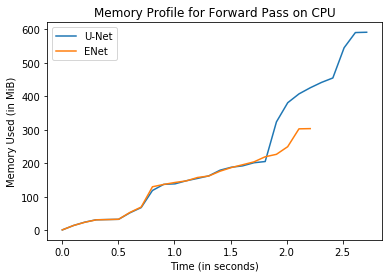

In [102]:
plt.figure()
plt.plot(unet_memprof[:,1]-unet_memprof[0,1],unet_memprof[:,0], label="U-Net")
plt.plot(enet_memprof[:,1]-enet_memprof[0,1],enet_memprof[:,0], label="ENet")
plt.xlabel('Time (in seconds)')
plt.ylabel("Memory Used (in MiB)")
plt.title("Memory Profile for Forward Pass on CPU")
plt.legend()

In [103]:
import logging

In [104]:
logging.getLogger().setLevel(logging.DEBUG)

In [108]:
logging.debug(ctx)

DEBUG:root:cpu(0)
